In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import sys

In [4]:
#pip install --force-reinstall numpy==1.22.5

In [5]:
#sys.path.append(os.path.abspath('/kaggle/working/efficientnet/efficientnet'))
#from tensorflow.keras.applications import EfficientNetB5
import tensorflow as tf
from pathlib import Path

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
!pip install --upgrade pip

In [7]:
pip install --upgrade keras

Note: you may need to restart the kernel to use updated packages.


In [8]:
# Standard dependencies
import cv2
import time
import scipy as sp
import numpy as np
import random as rn
import pandas as pd
from tqdm import tqdm
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
import keras

In [9]:
# Path specifications
KAGGLE_DIR = '/kaggle/input/diabetic-retinopathy-resized/'
TRAIN_DF_PATH = KAGGLE_DIR + "trainLabels_cropped.csv"
TEST_DF_PATH = '/kaggle/input/aptos2019-blindness-detection/test.csv'
TRAIN_IMG_PATH = KAGGLE_DIR + "resized_train/resized_train/"
TEST_IMG_PATH = '/kaggle/input/aptos2019-blindness-detection/test_images/'

# Specify title of our final model
SAVED_MODEL_NAME = 'effnet_modelB5.h5'

In [10]:
# Set seed for reproducability
seed = 1234
rn.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# For keeping time. GPU limit for this competition is set to ± 9 hours.
t_start = time.time()

In [11]:
# File sizes and specifications
print('\n# Files and file sizes')
for file in os.listdir(KAGGLE_DIR):
    print('{}| {} MB'.format(file.ljust(30), 
                             str(round(os.path.getsize(KAGGLE_DIR + file) / 1000000, 2))))


# Files and file sizes
resized_train                 | 0.0 MB
trainLabels.csv               | 0.47 MB
resized_train_cropped         | 0.0 MB
trainLabels_cropped.csv       | 0.9 MB


In [12]:
print("Image IDs and Labels (TRAIN)")
train_df = pd.read_csv(TRAIN_DF_PATH)
# Add extension to id_code
train_df['image'] = train_df['image'] + ".jpeg"
print(f"Training images: {train_df.shape[0]}")
display(train_df.head())
display(train_df.describe())
print("Image IDs (TEST)")
test_df = pd.read_csv(TEST_DF_PATH)
# Add extension to id_code
test_df['id_code'] = test_df['id_code'] + ".png"
print(f"Testing Images: {test_df.shape[0]}")
display(test_df.head())
display(test_df.describe())

Image IDs and Labels (TRAIN)
Training images: 35108


,Unnamed: 0.1,Unnamed: 0,image,level
0,0,0,10_left.jpeg,0
1,1,1,10_right.jpeg,0
2,2,2,13_left.jpeg,0
3,3,3,13_right.jpeg,0
4,4,4,15_left.jpeg,1


,Unnamed: 0.1,Unnamed: 0,level
count,35108.000000,35108.000000,35108.000000
mean,17553.520992,17563.923778,0.525863
std,10134.986560,10139.840349,0.970372
min,0.000000,0.000000,0.000000
25%,8776.750000,8783.750000,0.000000
50%,17553.500000,17565.500000,0.000000
75%,26330.250000,26345.250000,1.000000
max,35108.000000,35125.000000,4.000000


Image IDs (TEST)
Testing Images: 1928


,id_code
0,0005cfc8afb6.png
1,003f0afdcd15.png
2,006efc72b638.png
3,00836aaacf06.png
4,009245722fa4.png


,id_code
count,1928
unique,1928
top,0005cfc8afb6.png
freq,1


In [13]:
# Specify image size
IMG_WIDTH = 456
IMG_HEIGHT = 456
CHANNELS = 3

In [52]:
def get_preds_and_labels(model, generator):
    """
    Get predictions and labels from the generator
    
    :param model: A Keras model object
    :param generator: A Keras ImageDataGenerator object
    
    :return: A tuple with two Numpy Arrays. One containing the predictions
    and one containing the labels
    """
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
    # Flatten list of numpy arrays
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()

In [15]:
from keras.callbacks import Callback
from sklearn.metrics import cohen_kappa_score

In [53]:
class Metrics(Callback):
    
    #A custom Keras callback for saving the best model
    #according to the Quadratic Weighted Kappa (QWK) metric
    
    def on_train_begin(self, logs={}):
        
        #Initialize list of QWK scores on validation data
        
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        
        #Gets QWK score on the validation data
        
        #:param epoch: The current epoch number
        
        # Get predictions and convert to integers
        y_pred, labels = get_preds_and_labels(model, val_generator)
        y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)
        # We can use sklearns implementation of QWK straight out of the box
        # as long as we specify weights as 'quadratic'
        _val_kappa = cohen_kappa_score(labels, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {round(_val_kappa, 4)}")
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save(SAVED_MODEL_NAME)
        return

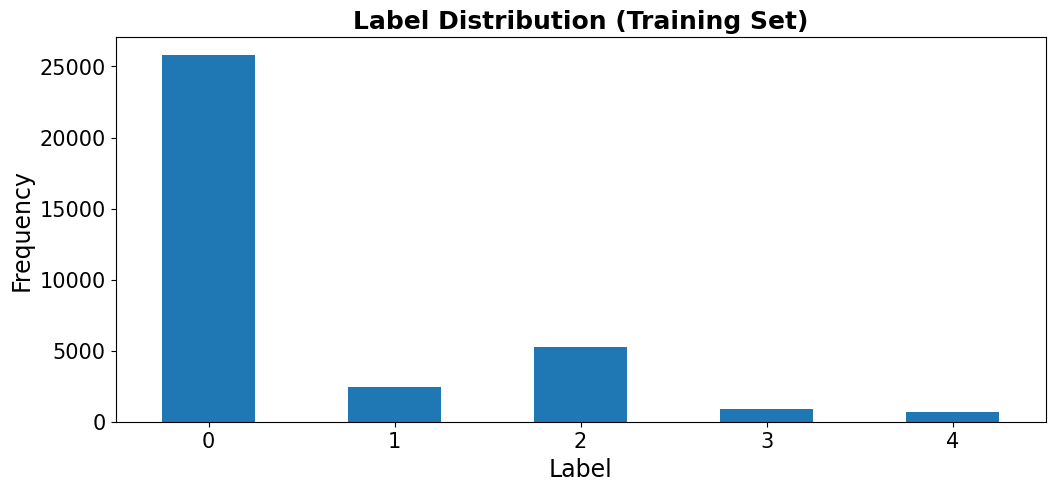

In [17]:
# Label distribution
train_df['level'].value_counts().sort_index().plot(kind="bar", 
                                                       figsize=(12,5), 
                                                       rot=0)
plt.title("Label Distribution (Training Set)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

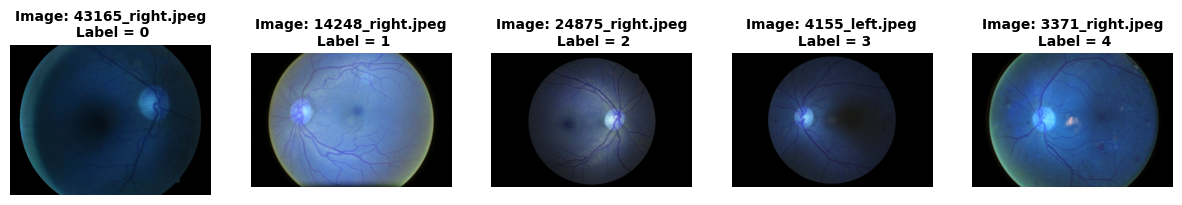

In [18]:
# Example from every label
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['level'] == i].sample(1)
    image_name = sample['image'].item()
    X = cv2.imread(f"{TRAIN_IMG_PATH}{image_name}")
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['level'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

In [19]:
def crop_image_from_gray(img, tol=7):

    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image, sigmaX=10):

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = cv2.addWeighted(image,4, cv2.GaussianBlur(image, (0,0), sigmaX), -4, 128)
    image = image / 255.0  # Rescale to [0.0, 1.0]
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - mean) / std  # Normalize

    return image

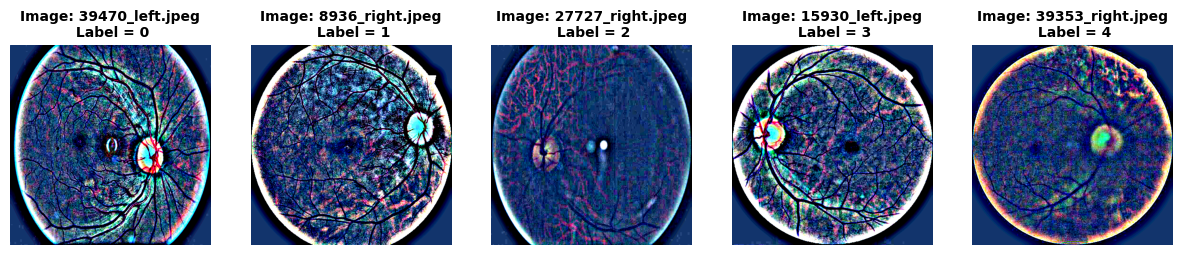

In [20]:
# Example of preprocessed images from every label
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['level'] == i].sample(1)
    image_name = sample['image'].item()
    X = preprocess_image(cv2.imread(f"{TRAIN_IMG_PATH}{image_name}"))
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['level'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

In [21]:
# Labels for training data
y_labels = train_df['level'].values

In [22]:
# We use a small batch size so we can handle large images easily
BATCH_SIZE = 4

In [23]:
from keras.preprocessing.image import ImageDataGenerator

In [54]:
# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.15,
                                   preprocessing_function=preprocess_image, 
                                )

# Use the dataframe to define train and validation generators
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='image', 
                                                    y_col='level',
                                                    directory = TRAIN_IMG_PATH,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='other', 
                                                    subset='training')

val_generator = train_datagen.flow_from_dataframe(train_df, 
                                                  x_col='image', 
                                                  y_col='level',
                                                  directory = TRAIN_IMG_PATH,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='other',
                                                  subset='validation')


Found 29842 validated image filenames.
Found 5266 validated image filenames.


In [25]:
#from keras.optimizers import RAdam

#optimizer = RAdam(lr=0.001)


In [26]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [27]:
from tensorflow import keras
from tensorflow.keras import backend as K

In [38]:
# Code Source: https://github.com/CyberZHG/keras-radam/blob/master/keras_radam/optimizers.py
class Adam(keras.optimizers.Adam):
    """RAdam optimizer.
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Weight decay for each param.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
        total_steps: int >= 0. Total number of training steps. Enable warmup by setting a positive value.
        warmup_proportion: 0 < warmup_proportion < 1. The proportion of increasing steps.
        min_lr: float >= 0. Minimum learning rate after warmup.
    # References
        - [Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
        - [On The Variance Of The Adaptive Learning Rate And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf)
    """

    def __init__(self,name = "Adam", learning_rate=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., weight_decay=0., amsgrad=False,
                 total_steps=0, warmup_proportion=0.1, min_lr=0., **kwargs):
        super(Adam, self).__init__(name, **kwargs)
        with K.name_scope(self.__class__.__name__):
            self.learning_rate = self.add_weight("learning_rate", initializer=learning_rate)
            #self.learning_rate = lr
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.learning_rate= K.variable(lr, name='lr')
            #self.lr= K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.weight_decay = K.variable(weight_decay, name='weight_decay')
            self.total_steps = K.variable(total_steps, name='total_steps')
            self.warmup_proportion = K.variable(warmup_proportion, name='warmup_proportion')
            self.min_lr = K.variable(lr, name='min_lr')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.initial_weight_decay = weight_decay
        self.initial_total_steps = total_steps
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr

        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        if self.initial_total_steps > 0:
            warmup_steps = self.total_steps * self.warmup_proportion
            decay_steps = self.total_steps - warmup_steps
            lr = K.switch(
                t <= warmup_steps,
                lr * (t / warmup_steps),
                lr * (1.0 - K.minimum(t, decay_steps) / decay_steps),
            )

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]

        self.weights = [self.iterations] + ms + vs + vhats

        beta_1_t = K.pow(self.beta_1, t)
        beta_2_t = K.pow(self.beta_2, t)

        sma_inf = 2.0 / (1.0 - self.beta_2) - 1.0
        sma_t = sma_inf - 2.0 * t * beta_2_t / (1.0 - beta_2_t)

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            m_corr_t = m_t / (1.0 - beta_1_t)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                v_corr_t = K.sqrt(vhat_t / (1.0 - beta_2_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                v_corr_t = K.sqrt(v_t / (1.0 - beta_2_t) + self.epsilon)

            r_t = K.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
                         (sma_t - 2.0) / (sma_inf - 2.0) *
                         sma_inf / sma_t)

            p_t = K.switch(sma_t > 5, r_t * m_corr_t / v_corr_t, m_corr_t)

            if self.initial_weight_decay > 0:
                p_t += self.weight_decay * p

            p_t = p - lr * p_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {
            'lr': float(K.get_value(self.lr)),
            'beta_1': float(K.get_value(self.beta_1)),
            'beta_2': float(K.get_value(self.beta_2)),
            'decay': float(K.get_value(self.decay)),
            'weight_decay': float(K.get_value(self.weight_decay)),
            'epsilon': self.epsilon,
            'amsgrad': self.amsgrad,
            'total_steps': float(K.get_value(self.total_steps)),
            'warmup_proportion': float(K.get_value(self.warmup_proportion)),
            'min_lr': float(K.get_value(self.min_lr)),
        }
        base_config = super(RAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [30]:
from tensorflow.keras.layers import Layer

In [31]:
class GroupNormalization(Layer):
    def __init__(self,groups=32,axis=-1,epsilon=1e-5,center=True,scale=True,beta_initializer='zeros',gamma_initializer='ones',beta_regularizer=None,gamma_regularizer=None,beta_constraint=None,gamma_constraint=None,**kwargs):
        super(GroupNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)
    def build(self, input_shape):
        dim = input_shape[self.axis]
        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +str(input_shape) + '.')
        if dim < self.groups:
            raise ValueError('Number of groups (' + str(self.groups) + ') cannot be '
                             'more than the number of channels (' +str(dim) + ').')
        if dim % self.groups != 0:
            raise ValueError('Number of groups (' + str(self.groups) + ') must be a '
                             'multiple of the number of channels (' +str(dim) + ').')
        self.input_spec = InputSpec(ndim=len(input_shape),axes={self.axis: dim})
        shape = (dim,)
        if self.scale:
            self.gamma = self.add_weight(shape=shape,name='gamma',initializer=self.gamma_initializer,regularizer=self.gamma_regularizer,constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,name='beta',initializer=self.beta_initializer,regularizer=self.beta_regularizer,constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True
    def call(self, inputs, **kwargs):
        input_shape = K.int_shape(inputs)
        tensor_input_shape = K.shape(inputs)
        # Prepare broadcasting shape.
        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
        broadcast_shape.insert(1, self.groups)
        reshape_group_shape = K.shape(inputs)
        group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
        group_axes[self.axis] = input_shape[self.axis] // self.groups
        group_axes.insert(1, self.groups)
        # reshape inputs to new group shape
        group_shape = [group_axes[0], self.groups] + group_axes[2:]
        group_shape = K.stack(group_shape)
        inputs = K.reshape(inputs, group_shape)
        group_reduction_axes = list(range(len(group_axes)))
        group_reduction_axes = group_reduction_axes[2:]
        mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
        variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)
        inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))
        # prepare broadcast shape
        inputs = K.reshape(inputs, group_shape)
        outputs = inputs
        # In this case we must explicitly broadcast all parameters.
        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            outputs = outputs * broadcast_gamma

        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            outputs = outputs + broadcast_beta

        outputs = K.reshape(outputs, tensor_input_shape)
        return outputs

    def get_config(self):
        config = {'groups': self.groups,'axis': self.axis,'epsilon': self.epsilon,'center': self.center,'scale': self.scale,'beta_initializer': initializers.serialize(self.beta_initializer),
                  'gamma_initializer': initializers.serialize(self.gamma_initializer),'beta_regularizer': regularizers.serialize(self.beta_regularizer),
                  'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),'beta_constraint': constraints.serialize(self.beta_constraint),'gamma_constraint': constraints.serialize(self.gamma_constraint)}
        base_config = super(GroupNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    def compute_output_shape(self, input_shape):
        return input_shape

In [32]:
#sys.path.append(os.path.abspath('/kaggle/working/efficientnet/efficientnet'))
from tensorflow.keras.applications import EfficientNetB5
# Load in EfficientNetB5
effnet = EfficientNetB5(weights=None,#'imagenet',
                        include_top=False,
                        input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))

effnet.load_weights('/kaggle/input/efficintnetb5/efficientnetb5_notop.h5')

In [33]:
# Replace all Batch Normalization layers by Group Normalization layers
for i, layer in enumerate(effnet.layers):
    if "batch_normalization" in layer.name:
        effnet.layers[i] = GroupNormalization(groups=32, axis=-1, epsilon=0.00001)

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.activations import elu
from keras.optimizers import Adam
from keras.losses import binary_crossentropy, categorical_crossentropy

In [35]:
kappa_metrics = Metrics()

In [74]:
'''def build_model():
    """
    A custom implementation of EfficientNetB5
    for the APTOS 2019 competition
    (Regression)
    """
    model = Sequential()
    model.add(effnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation=elu))
    model.add(Dense(5, activation='softmax'))
    #model.add(Dense(5, activation=elu))
    #model.add(Dense(1, activation="linear"))
    model.compile(loss='categorical_crossentropy',
                  optimizer= Adam(lr=1e-4,decay=1e-6), 
                  metrics=[kappa_metrics,'categorical_crossentropy', 'acc'])
    print(model.summary())
    return model

# Initialize model
model = build_model()'''

def build_model():
    """
    A custom implementation of EfficientNetB5
    for the APTOS 2019 competition
    (Regression)
    """
    model = Sequential()
    model.add(effnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(5, activation=elu))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mse',
                  optimizer=Adam(lr=1e-4,decay=1e-6), 
                  metrics=['mse', 'acc'])
    print(model.summary())
    return model

# Initialize model
model = build_model()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 15, 15, 2048)     28513527  
                                                                 
 global_average_pooling2d_8   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 5)                 10245     
                                                                 
 dense_12 (Dense)            (None, 1)                 6         
                                                                 
Total params: 28,523,778
Trainable params: 28,351,035
Non-trainable params: 172,743
____________________________________

In [50]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

In [75]:
# For tracking Quadratic Weighted Kappa score
kappa_metrics = Metrics()
# Monitor to avoid overfitting and save best model
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=12)
rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4, 
                        verbose=1, 
                        mode='auto', 
                        epsilon=0.0001)

# Begin training
model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=5,
                    validation_data=val_generator,
                    validation_steps = val_generator.samples // BATCH_SIZE,
                    callbacks=[kappa_metrics, es, rlr])

Epoch 1/5


2023-11-05 09:49:17.161462: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/efficientnetb5/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 1s 575ms/step
val_kappa: 0.6093
Validation Kappa has improved. Saving model.
7460/7460 [==============================] - 3907s 521ms/step - loss: 0.4999 - mse: 0.4999 - acc: 0.6355 - val_loss: 0.4968 - val_mse: 0.4968 - val_acc: 0.7236 - lr: 1.0000e-04
Epoch 2/5
1/1 [==============================] - 0s 35ms/step
val_kappa: 0.725
Validation Kappa has improved. Saving model.
7460/7460 [==============================] - 3824s 513ms/step - loss: 0.4309 - mse: 0.4309 - acc: 0.6616 - val_loss: 0.4729 - val_mse: 0.4729 - val_acc: 0.6822 - lr: 1.0000e-04
Epoch 3/5
1/1 [==============================] - 0s 36ms/step
val_kappa: 0.7316
Validation Kappa has improved. Saving model.
7460/7460 [==============================] - 3842s 515ms/step - loss: 0.3896 - mse: 0.3896 - acc: 0.6751 - val_loss: 0.4490 - val_mse: 0.4490 - val_acc: 0.6968 - lr: 1.0000e-04
Epoch 4/5
1/1 [==============================] - 0s 36ms/step
val_kappa: 0.7399
Validation Kappa has imp

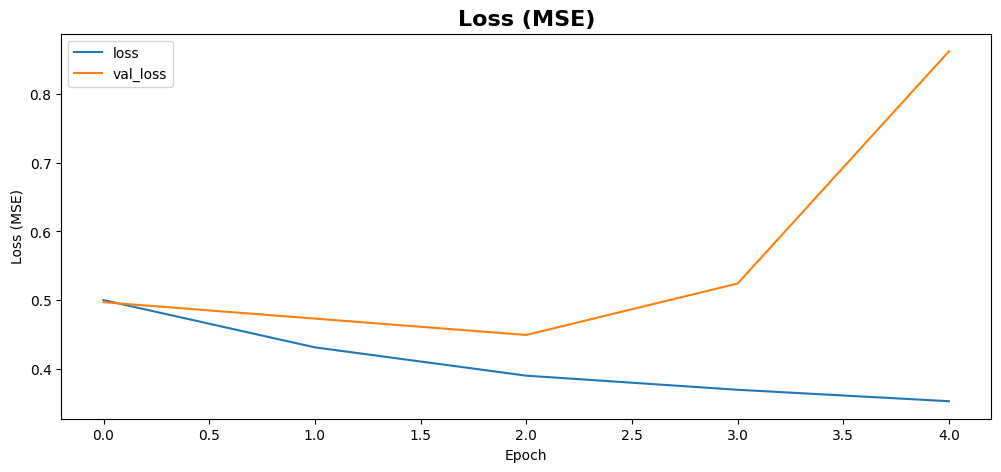

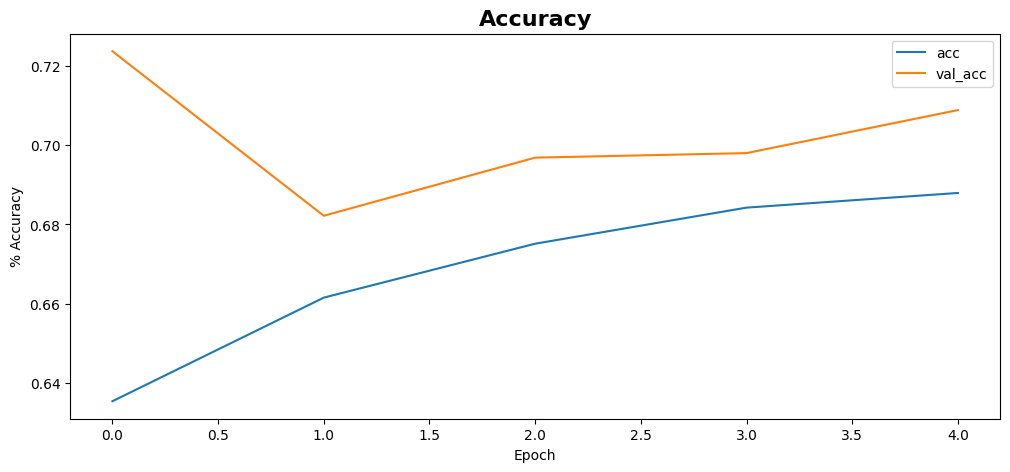

In [76]:
# Visualize mse
history_df = pd.DataFrame(model.history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['acc', 'val_acc']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");

In [77]:
# Load best weights according to MSE
model.load_weights(SAVED_MODEL_NAME)

In [78]:
# Calculate QWK on train set
y_train_preds, train_labels = get_preds_and_labels(model, train_generator)
y_train_preds = np.rint(y_train_preds).astype(np.uint8).clip(0, 4)

# Calculate score
train_score = cohen_kappa_score(train_labels, y_train_preds, weights="quadratic")

# Calculate QWK on validation set
y_val_preds, val_labels = get_preds_and_labels(model, val_generator)
y_val_preds = np.rint(y_val_preds).astype(np.uint8).clip(0, 4)

# Calculate score
val_score = cohen_kappa_score(val_labels, y_val_preds, weights="quadratic")

1/1 [==============================] - 0s 41ms/step


In [79]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_val_preds, val_labels)
print(confusion)
from sklearn.metrics import classification_report
report = classification_report(y_val_preds, val_labels)
print(report)

[[3620  259  218    5    2]
 [ 216   76  183    7    3]
 [  31   29  377   56   19]
 [   1    0   44   45   32]
 [   0    0    3    1   39]]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      4104
           1       0.21      0.16      0.18       485
           2       0.46      0.74      0.56       512
           3       0.39      0.37      0.38       122
           4       0.41      0.91      0.57        43

    accuracy                           0.79      5266
   macro avg       0.48      0.61      0.52      5266
weighted avg       0.81      0.79      0.79      5266



In [80]:
print(f"The Training Cohen Kappa Score is: {round(train_score, 5)}")
print(f"The Validation Cohen Kappa Score is: {round(val_score, 5)}")

The Training Cohen Kappa Score is: 0.78994
The Validation Cohen Kappa Score is: 0.7566


In [81]:
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa score
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [82]:
# Optimize on validation data and evaluate again
y_val_preds, val_labels = get_preds_and_labels(model, val_generator)
optR = OptimizedRounder()
optR.fit(y_val_preds, val_labels)
coefficients = optR.coefficients()
opt_val_predictions = optR.predict(y_val_preds, coefficients)
new_val_score = cohen_kappa_score(val_labels, opt_val_predictions, weights="quadratic")

1/1 [==============================] - 0s 36ms/step


In [83]:
print(f"Optimized Thresholds:\n{coefficients}\n")
print(f"The Validation Quadratic Weighted Kappa (QWK)\n\
with optimized rounding thresholds is: {round(new_val_score, 5)}\n")
print(f"This is an improvement of {round(new_val_score - val_score, 5)}\n\
over the unoptimized rounding")

Optimized Thresholds:
[0.52928804 1.56041085 2.06936014 3.4989572 ]

The Validation Quadratic Weighted Kappa (QWK)
with optimized rounding thresholds is: 0.76488

This is an improvement of 0.00827
over the unoptimized rounding


In [84]:
# Place holder for diagnosis column
test_df['diagnosis'] = np.zeros(test_df.shape[0]) 
# For preprocessing test images
test_generator = ImageDataGenerator(preprocessing_function=preprocess_image, 
                                    rescale=1 / 128.).flow_from_dataframe(test_df, 
                                                                          x_col='id_code', 
                                                                          y_col='diagnosis',
                                                                          directory=TEST_IMG_PATH,
                                                                          target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                                          batch_size=BATCH_SIZE,
                                                                          class_mode='other',
                                                                          shuffle=False)

Found 1928 validated image filenames.


In [85]:
# Make final predictions, round predictions and save to csv
y_test, _ = get_preds_and_labels(model, test_generator)
y_test = optR.predict(y_test, coefficients).astype(np.uint8)
test_df['diagnosis'] = y_test
# Remove .png from ids
test_df['id_code'] = test_df['id_code'].str.replace(r'.png$', '')
test_df.to_csv('submission.csv', index=False)

1/1 [==============================] - 0s 38ms/step


In [92]:
# Check submission
print("Submission File")
display(test_df.head())

Submission File


,id_code,diagnosis
0,0005cfc8afb6.png,2
1,003f0afdcd15.png,2
2,006efc72b638.png,2
3,00836aaacf06.png,2
4,009245722fa4.png,2


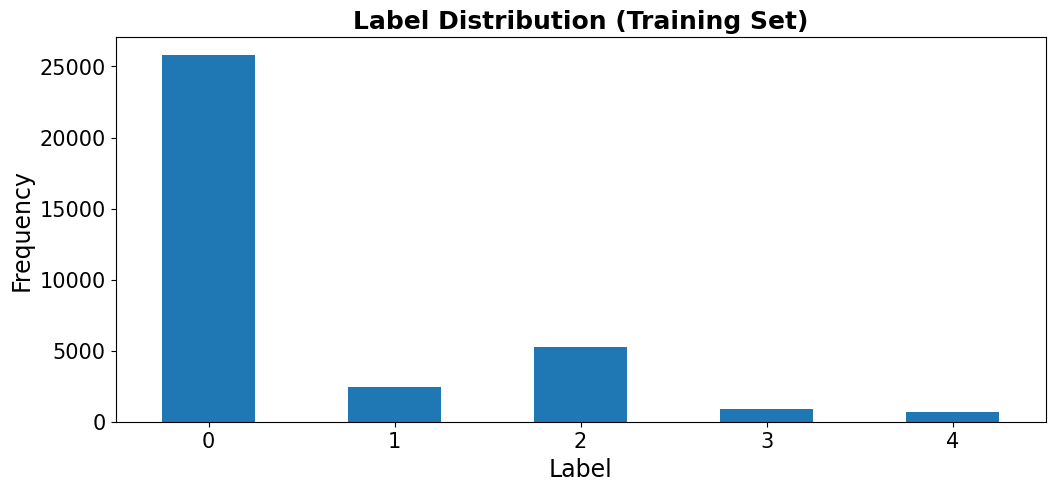

In [93]:
# Label distribution
train_df['level'].value_counts().sort_index().plot(kind="bar", 
                                                       figsize=(12,5), 
                                                       rot=0)
plt.title("Label Distribution (Training Set)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

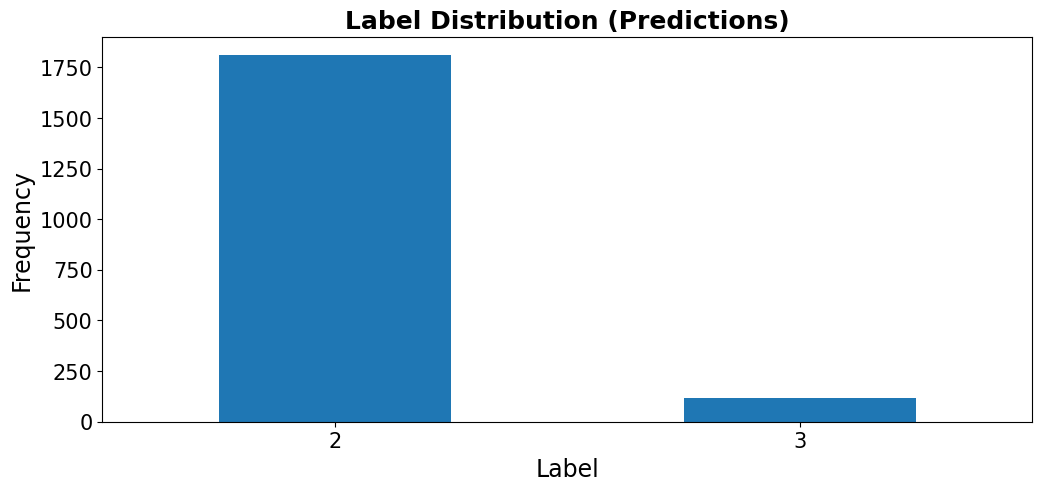

In [94]:
# Distribution of predictions
test_df['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                      figsize=(12,5), 
                                                      rot=0)
plt.title("Label Distribution (Predictions)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

In [95]:
# Check kernels run-time. GPU limit for this competition is set to ± 9 hours.
t_finish = time.time()
total_time = round((t_finish-t_start) / 3600, 4)
print('Kernel runtime = {} hours ({} minutes)'.format(total_time, 
                                                      int(total_time*60)))

Kernel runtime = 8.4294 hours (505 minutes)
